# Breaking down the Jupyter notebook monolith: Building reliable notebook-based pipelines with Ploomber

Scipy 2021.

Author: [Eduardo Blancas](https://twitter.com/edublancas)

## Introduction

Notebooks are an excellent environment for data exploration: they allow us to write code interactively and get visual feedback, providing an unbeatable experience for understanding our data.

However, this convenience comes at a cost: if we are not careful about adding and removing code cells, we may end up with an irreproducible notebook. Arbitrary execution order is a prevalent problem: A [recent analysis](https://blog.jetbrains.com/datalore/2020/12/17/we-downloaded-10-000-000-jupyter-notebooks-from-github-this-is-what-we-learned/) found that about 36% of notebooks on GitHub did not execute in linear order. To ensure our notebooks run, we must continuously test them to catch these problems.

A second notable problem is the size of notebooks: the more cells we have, the more difficult it is to debug since there are more variables and code involved.

Software engineers typically break down projects into multiple steps and test continuously to prevent broken and unmaintainable code. However, applying these ideas for data analysis requires extra work: multiple notebooks imply we have to ensure the output from one stage becomes the input for the next one. Furthermore, we can no longer press "Run all cells" in Jupyter to test our analysis from start to finish.

Ploomber provides all the necessary tools to build multi-stage, reproducible pipelines in Jupyter that feel like a single notebook. Users can easily break down their analysis into multiple notebooks and execute them all with a single command.

## Creating a pipeline in Ploomber

To develop a pipeline, users create a `pipeline.yaml` file and declare the tasks and their outputs as follows:

```yaml
tasks:
  - source: script.py
    product:
      nb: output/executed.ipynb
      data: output/data.csv
  
  # more tasks here...
```

The previous pipeline has a single task (`script.py`) and generates two outputs: `output/executed.ipynb` and `output/data.csv`. You may be wondering why we have a notebook as an output. Ploomber converts scripts to notebooks before execution; hence, our script is considered the source and the notebook a byproduct of the execution. The use of scripts as sources (instead of notebooks) has the advantage of being easier to version on git. However, this does not mean you have to give up interactive development since Ploomber integrates with Jupyter allowing you to edit scripts as notebooks.

Let's now build a simple four-step pipeline:

```yaml
meta:
  jupyter_hot_reload: True

tasks:
  - source: scripts/get.py
    product:
      nb: output/get.ipynb
      data: output/get.csv

  - source: scripts/feature-sepal.py
    product:
      nb: output/feature-sepal.ipynb
      data: output/feature-sepal.csv

  - source: scripts/feature-petal.py
    product:
      nb: output/feature-petal.ipynb
      data: output/feature-petal.csv

  - source: scripts/fit.py
    product:
      nb: output/fit.ipynb
      model: output/model.pickle
```

The pipeline above has four tasks: one that obtains raw data (the iris dataset), two that process such data, and a final task that trains a model. Copy the contents of the snippet above into `playground/pipeline.yaml`.

Our source code is still missing; let's ask Ploomber to generate some base files for us:

In [2]:
%%sh
cd playground
ploomber scaffold

Found spec at /Users/Edu/dev/scipy-2021/playground
Adding /Users/Edu/dev/scipy-2021/playground/scripts/get.py...
Adding /Users/Edu/dev/scipy-2021/playground/scripts/feature-sepal.py...
Adding /Users/Edu/dev/scipy-2021/playground/scripts/feature-petal.py...
Adding /Users/Edu/dev/scipy-2021/playground/scripts/fit.py...


Let's now ensure that our pipeline is appropriately recognized:

In [3]:
%%sh
cd playground
ploomber status

name      Last run     Outdated?    Product      Doc          Location
                                                 (short)
--------  -----------  -----------  -----------  -----------  -----------
fit       23 hours     Source code  MetaProduct  Add          /Users/Edu/
          ago (Jun                  ({'model':   description  dev/scipy-2
          21, 21 at                 File('outpu  here         021/playgro
          22:56)                    t/model.pic               und/scripts
                                    kle'),                    /fit.py
                                    'nb': File(
                                    'output/fit
                                    .ipynb')})
feature-  a day ago    Source code  MetaProduct  Add          /Users/Edu/
petal     (Jun 21, 21               ({'data': F  description  dev/scipy-2
          at 22:43)                 ile('output  here         021/playgro
                                    /...re-peta               und/s

100%|██████████| 4/4 [00:00<00:00, 5135.36it/s]


We can see that Ploomber recognizes our pipeline and prints its status. Let's visualize it:

In [4]:
%%sh
cd playground
ploomber plot

Plot saved at: pipeline.png


100%|██████████| 4/4 [00:00<00:00, 2540.85it/s]


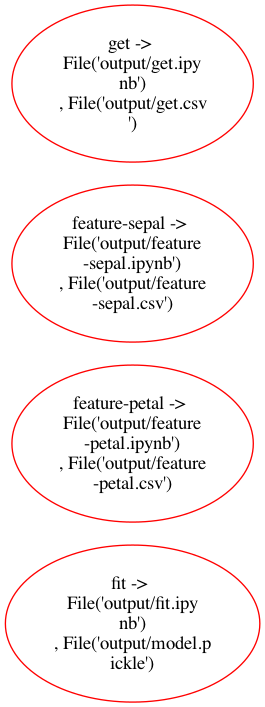

In [5]:
from IPython.display import Image
Image('playground/pipeline.png')

Our pipeline doesn't have any structure yet, but we can easily add it. We want to get data first, then process the data, then fit a model. Let's edit those files. Open `playground/scripts/features-petal.py` as a notebook by right-clicking on it and then `Open With` -> `Notebook`:

![lab-open-with-notebook](images/lab-open-with-notebook.png)

At the top of the notebook, you'll see the following:

```python
upstream = None
```

This special variable indicates which tasks should execute before the notebook we're currently working on. In this case, we want to get the raw data so we can process it here, so we do:

```python
upstream = ['get']
```

After editing, click on `File` -> `Reload Python File from Disk`:

![reload-file](images/reload-file.png)

You'll see that the script updates. Since you said you want to execute `get` first, Ploomber adds a new cell that contains the output location of `get`. Ploomber makes it simple to assemble a data pipeline from multiple notebooks!

Let's continue declaring the remaining dependencies for the other tasks:

1. Edit `playground/scripts/features-sepal.py` and change `upstream = None` to `upstream = ['get']`
2. Edit `playground/scripts/fit.py` and change `upstream = None` to `upstream = ['get', 'feature-sepal', 'feature-petal']`

Let's now re-create the pipeline plot:

In [ ]:
%%sh
cd playground
ploomber plot

In [ ]:
from IPython.display import Image
Image('playground/pipeline.png')


Ploomber recognizes the references and draws the dependency relationship among tasks.

Our pipeline doesn't do anything yet. Let's add some code. Edit the files and add the following:

**Important:** make sure you add the code in a new cell **at the end** of the notebook.

### `playground/scripts/get.py`

```python
# get raw data
import pandas as pd
from sklearn.datasets import load_iris

raw = load_iris(as_frame=True)
df = raw['data']
df.head()
df['target'] = raw['target']
df.to_csv(product['data'], index=False)
```

### `playground/scripts/feature-sepal.py`

```python
# generate one feature
import pandas as pd

df = pd.read_csv(upstream['get']['data'])
df['sepal-area'] = df['sepal length (cm)'] * df['sepal width (cm)']
df[['sepal-area']].to_csv(product['data'], index=False)
```

### `playground/scripts/feature-petal.py`

```python
# generate another feature
import pandas as pd

df = pd.read_csv(upstream['get']['data'])
df['petal-area'] = df['petal length (cm)'] * df['petal width (cm)']
df[['petal-area']].to_csv(product['data'], index=False)
```

### `playground/scripts/fit.py`

```python
# train a model and save it
from pathlib import Path
import pickle

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn_evaluation import plot

get = pd.read_csv(upstream['get']['data'])
petal = pd.read_csv(upstream['feature-sepal']['data'])
sepal = pd.read_csv(upstream['feature-petal']['data'])
df = get.join(petal).join(sepal)

X = df.drop('target', axis='columns')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
Path(product['model']).write_bytes(pickle.dumps(model))

y_pred = model.predict(X_test)

plot.confusion_matrix(y_test, y_pred)
```

We can now run our pipeline:

In [ ]:
%%sh
cd playground
ploomber build

Navigate to `playground/output/` and you'll see all the outputs: the executed notebooks, data files and trained model.

## Incremental builds

Data workflows require a lot of iteration. For example, you may want to generate a new feature or model. It's wasteful to re-execute every task with every minor change. One of Ploomber's core features is incremental builds, which automatically skip tasks whose source code hasn't changed.

Let's go ahead and modify `playground/scripts/fit.py`, by adding a summary table as a new cell at the end:

```python
# add this at the bottom of playground/scripts/fit.py
from sklearn.metrics import classification_report
classification_report(y_test, y_pred)
```

Run the pipeline again:

In [ ]:
%%sh
cd playground
ploomber build

You can see from the summary table that only the `fit` task executes! Incremental builds allow us to iterate faster without having to keep track of task changes.

## Execution in the cloud

When working with datasets that fit in memory, running your pipeline is simple enough, but sometimes you may need more computing power for your analysis. Ploomber makes it simple to execute your code in a distributed environment without code changes.

Check out [Soopervisor](soopervisor.readthedocs.io), the package that implements exporting Ploomber projects in the cloud with support for:

* [Kubernetes (Argo Workflows)](https://soopervisor.readthedocs.io/en/latest/tutorials/kubernetes.html)
* [AWS Batch](https://soopervisor.readthedocs.io/en/latest/tutorials/aws-batch.html)
* [Airflow](https://soopervisor.readthedocs.io/en/latest/tutorials/airflow.html)

# Resources

Thanks for taking the time to go through this tutorial! We hope you consider using Ploomber for your next project. If you have any questions or need help, please reach out to us! (contact info below).

Here are a few resources to dig deeper:

* [GitHub](https://github.com/ploomber/ploomber)
* [Documentation](https://ploomber.readthedocs.io/)
* [Code examples](https://github.com/ploomber/projects)
* [JupyterCon 2020 talk](https://www.youtube.com/watch?v=M6mtgPfsA3M)
* [Argo Community Meeting talk](https://youtu.be/FnpXyg-5W_c)
* [Pangeo Showcase talk (AWS Batch demo)](https://youtu.be/XCgX1AszVF4)

# Contact

* E-mail: [contact@ploomber.io](mailto:contact@ploomber.io)
* [Twitter](https://twitter.com/ploomber)
* [Google form](https://forms.gle/Xf9h1Q2TGoSk15NEA)
* [Join us on Slack](https://join.slack.com/t/ploomber-io/shared_invite/zt-rzu2e9f6-kaWgCfsLY~xeJ9vG9EIuBw)